# Vehicle Detection and Tracking
## Udacity Self Driving Car Engineer Nanodegree - Project 5

The goal of this project is to use Histogram of Oriented Gradients to:
- Identify vehicles in images
- Track vehicles across frames in a video stream

In [3]:
# Import Libraries
import cv2
import numpy as np
import pandas as pd
from skimage.feature import hog
from skimage.io import imread
from scipy.misc import imresize
import matplotlib.pyplot as plt
from sklearn.externals import joblib
import matplotlib.image as mpimg
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from moviepy.editor import VideoFileClip
%matplotlib inline
print('Loaded')

Loaded


### Drawing Rectangles on images
The first step is to define a function `draw_boxes` which will be used later to draw bounding rectangles around identified vehicles in images.

In [4]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # make a copy of the image
    draw_img = np.copy(img)
    # draw each bounding box on your image copy using cv2.rectangle()
    for box in bboxes:
        cv2.rectangle(draw_img, box[0], box[1], color, thick)
    return draw_img

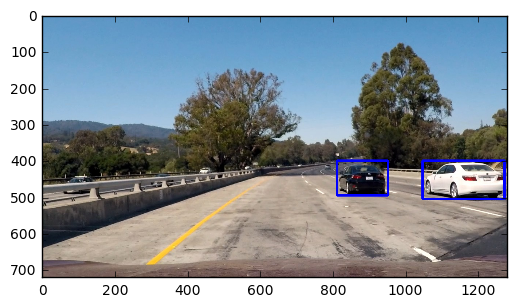

In [4]:
bboxes = [((810,400),(950,495)),((1045,400),(1270,505))]
plt.imshow(draw_boxes(mpimg.imread('test_images/test1.jpg'),bboxes=bboxes));

### Histogram of Oriented Gradients
Next, I will define a function `get_hog_features` which will be used to compute a Histogram of Oriented Gradients for a given image.  

In [5]:
def get_hog_features(img, color_space='YUV'):
    # Call with two outputs if vis==True
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'Lab':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)

    return np.ravel(hog.compute(feature_image))

In [31]:
hog = cv2.HOGDescriptor((64,64), (8,8), (8,8), (8,8), 9)
image = imread('test_images/test1.jpg')
hog.compute(image).shape

(7314624, 1)

In [6]:
# Load car and non-car image sets
cars = glob.glob('vehicles/*/*.png')
notcar = glob.glob('non-vehicles/*/*.png')

Next I will extract the HOG features and build datasets of Car and Non-car images to train a classifier

In [8]:
def extract_features(imgs, color_space='RGB', size = (64,64)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    hog = cv2.HOGDescriptor((64,64), (16,16), (8,8), (8,8), 9)
    for img in imgs:
        img = imread(img)
        if size != (64,64):
            img = cv2.resize(img, size)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'Lab':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img) 

        hog_features = np.ravel(hog.compute(feature_image))
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [9]:
# Build the datasets
car_features = extract_features(cars, color_space='YUV')
notcar_features = extract_features(notcar, color_space='YUV')

In [10]:
# Check the number of features for each image
car_features[0].shape

(1764,)

Before training the classifier I will first scale the features to have zero mean and unit variance. 

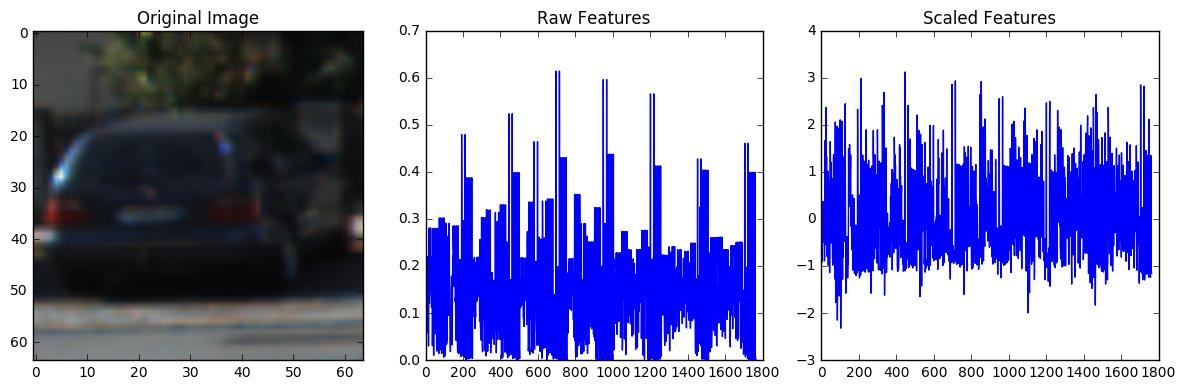

In [11]:
if len(car_features) > 0:
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Scaled Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

In [12]:
# Create Labels Array
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = 4444
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### Training classifiers
- First I will train a Linear Support Vector Machine

In [11]:
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', svc.score(X_train, y_train))
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = svc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with SVC')

8.789634943008423 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.95213963964
0.0018749237060546875 Seconds to predict with SVC


- Next a Logistic Regression Classifier

In [12]:
from sklearn.linear_model import LogisticRegression
lrc = LogisticRegression(max_iter=10)
t=time.time()
lrc.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train LRC...')
print('Train Accuracy of LRC = ', lrc.score(X_train, y_train))
print('Test Accuracy of LRC = ', lrc.score(X_test, y_test))
t=time.time()
prediction = lrc.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with LRC')

8.908768892288208 Seconds to train LRC...
Train Accuracy of LRC =  0.997536599099
Test Accuracy of LRC =  0.95777027027
0.00017881393432617188 Seconds to predict with LRC


- Finally, a Multi-Layer Perceptron classifier

In [14]:
mlp=MLPClassifier(random_state=999)
t=time.time()
mlp.fit(X_train, y_train)
t2 = time.time()
print(t2-t, 'Seconds to train MLP...')
# Check the score of the MLP
print('Train Accuracy of MLP = ', mlp.score(X_train, y_train))
print('Test Accuracy of MLP = ', mlp.score(X_test, y_test))
# Check the prediction time for a single sample
t=time.time()
prediction = mlp.predict(X_test[0].reshape(1, -1))
t2 = time.time()
print(t2-t, 'Seconds to predict with MLP')

9.683187007904053 Seconds to train MLP...
Train Accuracy of MLP =  1.0
Test Accuracy of MLP =  0.991835585586
0.0004019737243652344 Seconds to predict with MLP


In [15]:
# Visualize a confusion matrix of the predictions from the MLP
pred = mlp.predict(X_test)
cm = pd.DataFrame(confusion_matrix(pred, y_test))
cm

,0,1
0,1790,22
1,7,1733


#### Although slightly slower than the other 2 classifiers, the MLP classifier has a much higher accuracy and it will be used to detect cars in images

In [29]:
# Save MLP and Scaler
joblib.dump(mlp, 'mlp1.pkl')
joblib.dump(X_scaler, 'scaler1.pkl')

['scaler1.pkl']

In [5]:
# Load MLP and Scaler
mlp = joblib.load('mlp1.pkl')
X_scaler = joblib.load('scaler1.pkl')

In [16]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) 
    ny_windows = np.int(yspan/ny_pix_per_step)
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = (xs+1)*nx_pix_per_step + x_start_stop[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = (ys+1)*ny_pix_per_step + y_start_stop[0]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

In [17]:
def annotate(image):
    image = imread(image)
    detected = []
    size = 320
    count = 0
    while size < 720:
        windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 660], 
                            xy_window=(size, size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(current,color_space='YUV')
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if mlp.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
            count += 1
        size += 16
    result = np.copy(image)
    mask = np.zeros_like(image)
    # Draw all of the boxes on a mask image
    mask = draw_boxes(mask, bboxes=detected, thick=-1)
    # Find the contours in the mask
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        # Get the coordinates of a bounding rect for each contour
        x,y,w,h = cv2.boundingRect(cnt)
        # Draw the bounding rectangles on the result image
        cv2.rectangle(result, (x, y), (x + w, y + h), (0,255,0), 6)
        M = cv2.moments(cnt)
        c = (int(M['m10'] / M['m00']), int(M['m01'] / M['m00']))
        cv2.circle(result, c, 15, (255, 0, 0), -1)
    f, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,6))
    f.tight_layout()
    ax1.axis('off')
    ax1.set_title('Image')
    ax1.imshow(image)
    ax2.axis('off')
    ax2.set_title('Car Detections')
    ax2.imshow(mask, cmap='hot')
    ax3.axis('off')
    ax3.set_title('Annotated Image')
    ax3.imshow(result)

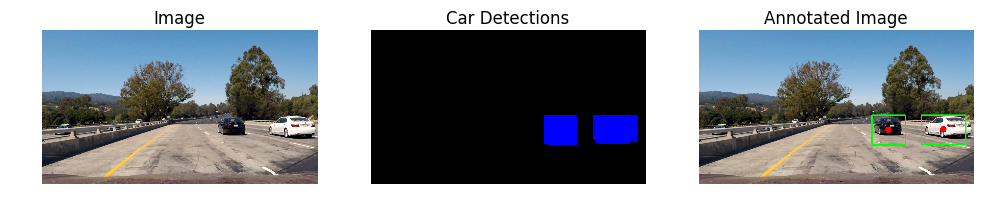

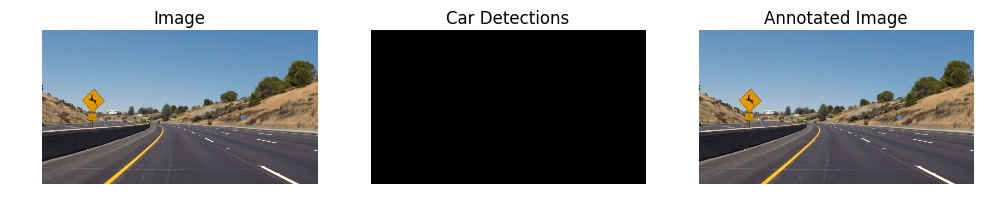

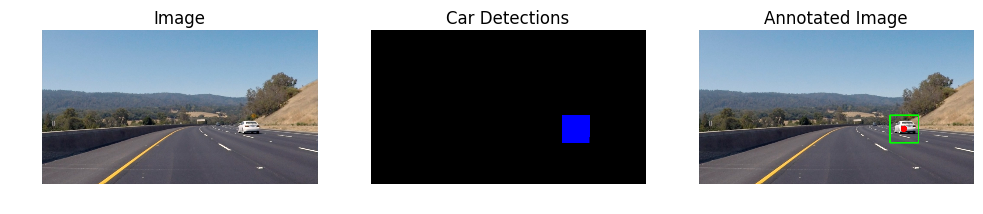

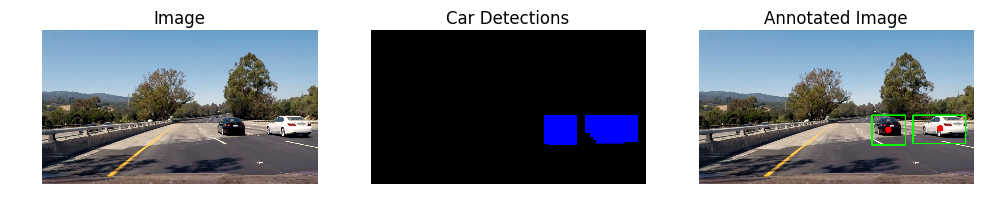

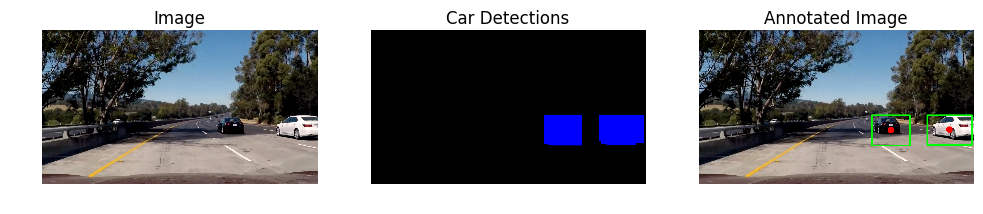

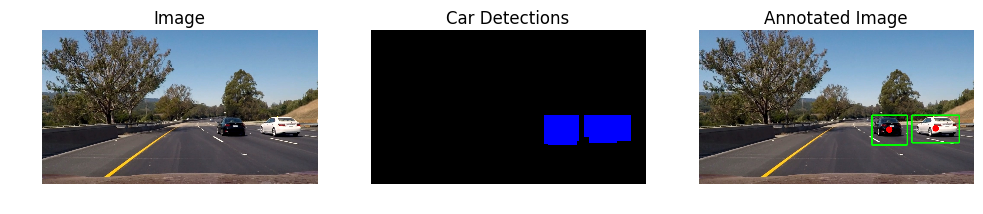

In [18]:
for image in glob.glob('test_images/*.jpg'):
    annotate(image);

In [24]:
from collections import deque
class boxes:
    def __init__(self):
        self.count = 0
        self.detections = deque(maxlen=12)

In [25]:
def process_vid(image):
    detected = [] 
    size = 320
    count = 0
    while size < 720:
        windows = slide_window(image, x_start_stop=[640, None], y_start_stop=[400, 660], 
                            xy_window=(size, size), xy_overlap=(0.8, 0.8))  
        for window in windows:
            features = []
            current = cv2.resize((image[window[0][1]: window[1][1], window[0][0]: window[1][0]]),(64,64))
            hog_features = get_hog_features(current, color_space='YUV')
            scaled_features = X_scaler.transform(hog_features)
            if current.shape[0] > 0:
                if mlp.predict_proba(scaled_features.reshape(1,-1))[0][1] > .99:
                    detected.append(window)
            count += 1
        size += 16
    result = np.copy(image).astype('uint8')
    mask = np.zeros_like(image)
    mask = draw_boxes(mask, bboxes=detected, thick=-1)
    rect_list = []
    im2, contours, hierarchy = cv2.findContours(mask[:,:,2].astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        rect_list.append([x,y,x+w,y+h])
    Boxes.detections.append(rect_list)
    all_boxes = []
    combined = np.ravel(np.array(Boxes.detections))
    for i in range(len(combined)):
        all_boxes.extend(np.ravel(combined[i]))
    new_boxes = []
    i = 0
    while i <= len(all_boxes)-3:
        new_boxes.append(all_boxes[i:i+4])
        i += 4
    rects,w = cv2.groupRectangles(np.array(new_boxes).tolist(), 10,.1)
    for rect in rects:
        cv2.rectangle(result, (rect[0], rect[1]), (rect[2],rect[3]), (0,255,0), 5)
    Boxes.count += 1
    return result

In [26]:
Boxes = boxes()
output = 'result.mp4'
clip1 = VideoFileClip('project_video.mp4').subclip(5,) # The first 5 seconds doesn't have any cars...
clip = clip1.fl_image(process_vid)
%time clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video result.mp4
[MoviePy] Writing video result.mp4


100%|█████████▉| 1135/1136 [05:03<00:00,  4.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result.mp4 

CPU times: user 4min 35s, sys: 6.76 s, total: 4min 41s
Wall time: 5min 4s
